# Import Library

In [1]:
# 기본 패키지
import os
import time
import pandas as pd
import numpy as np

# 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 모델링 패키지
import sklearn
import matplotlib
# import pycaret
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import silhouette_samples, silhouette_score

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
# print('pycaret : %s'%(pycaret.__version__))
!python --version

C:\Users\zyunhyeok\anaconda3\envs\spare\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zyunhyeok\anaconda3\envs\spare\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\zyunhyeok\anaconda3\envs\spare\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\zyunhyeok\anaconda3\envs\spare\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Pandas : 1.4.2
Numpy : 1.23.1
Scikit-Learn : 0.23.2
seaborn : 0.11.2
matplotlib : 3.5.2
Python 3.9.12


# Load Data

In [2]:
# 01_Data Preprocess에서 전처리했던 데이터 불러오기
df = pd.read_csv("../data/01_Data_Preprocess.csv")
print(df.shape)
df.head(3)

(4745877, 23)


,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,신규확진자,신규사망자
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000,1,...,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2021-01-01,824.0,25.0
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700,1,...,40대,Z13,Z13,Z13001,기타주방일회용품,주방잡화,주방일회용품,2021-01-01,824.0,25.0
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000,1,...,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2021-01-01,824.0,25.0


# Data Preprocess  
- train, test split

In [3]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
imp = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
imp['거래횟수'] = imp['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = imp[imp['거래횟수']>3]['고객번호'].tolist()
newbie = imp[imp['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

# RFM

In [4]:
# 고객을 RFM을 score를 이용하여 군집을 나누기 위하여 고객별 RFM 생성
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [5]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')
# df_rfm['Recency'] = [x.total_seconds() for x in df_rfm['Recency']]

df_rfm['Recency'] = df_rfm['Recency'].dt.days # days로
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

In [6]:
# Kmeans를 진행하기 전에 Scaling
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])
rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


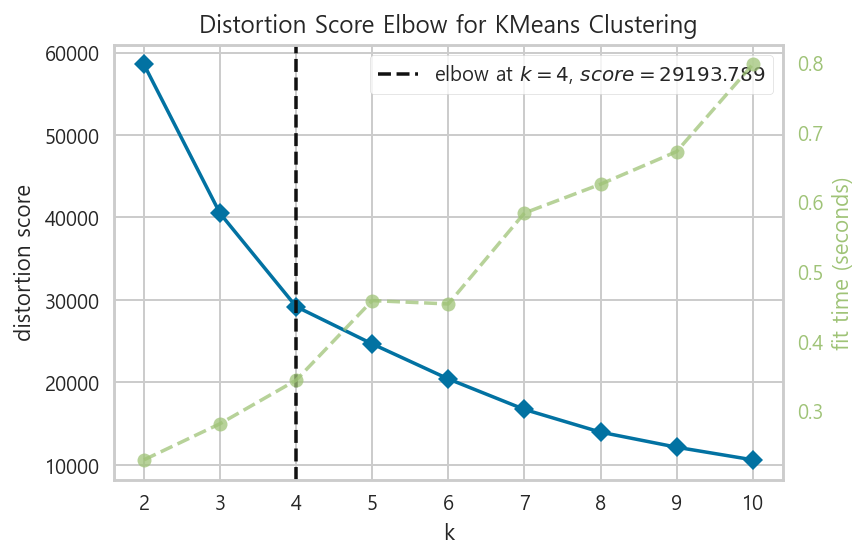

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
# 최적의 군집의 갯수 탐색
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

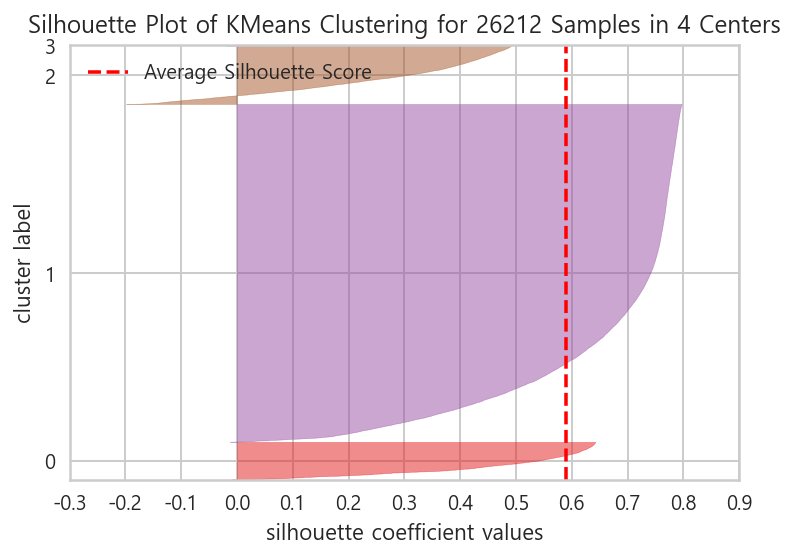

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [8]:
# 최적의 군집수 4개의 실루엣 계수 확인
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(rfm_scaled_df.iloc[:,1:])
sil_visualizer.show()

In [9]:
# 군집라벨링, 군집의 라벨이 바뀌는 것을 방지하기 위하여 random_state 값을 고정
kmeans = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

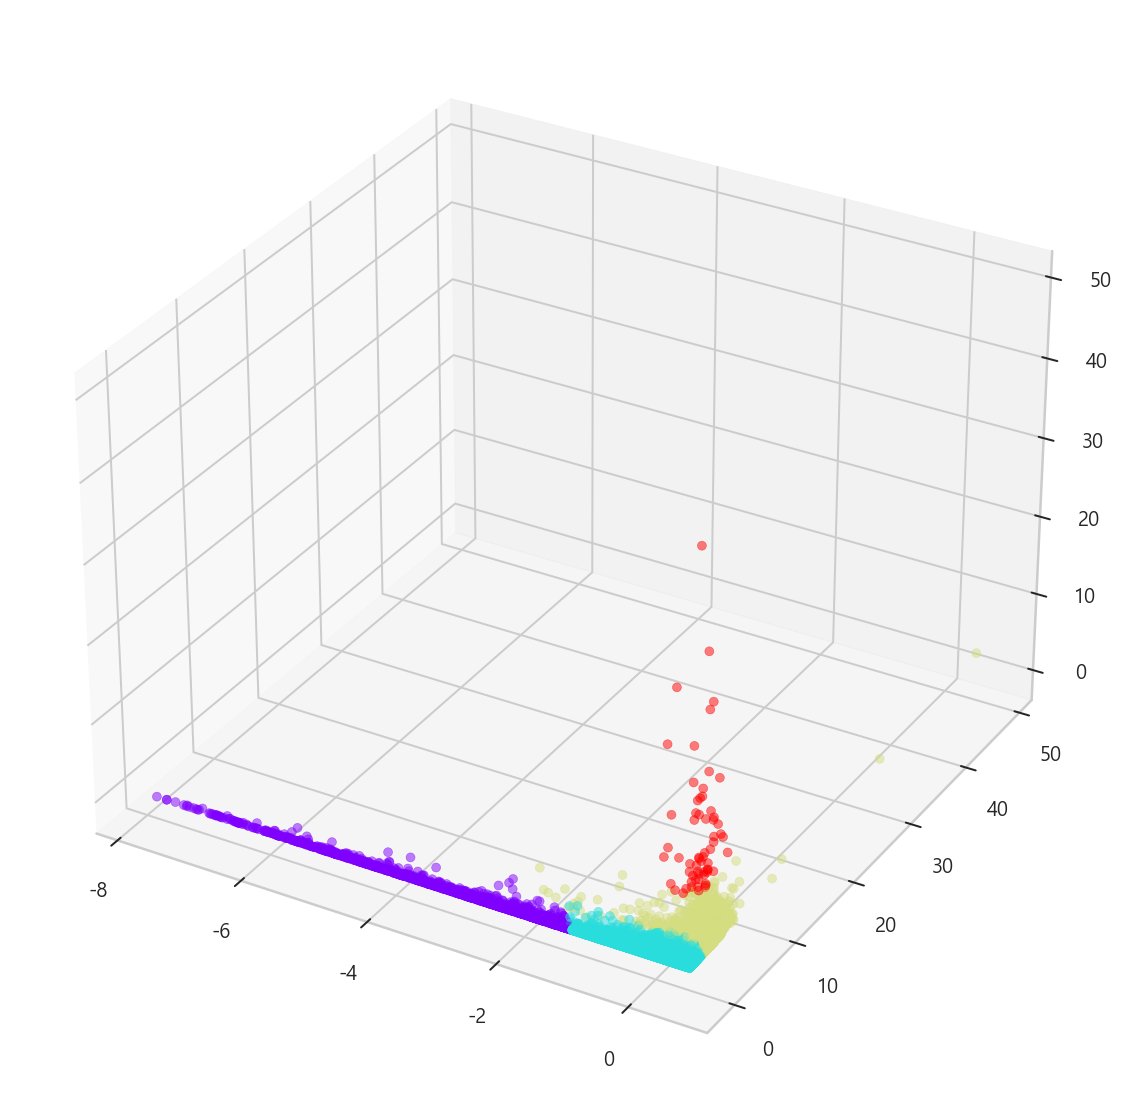

In [10]:
# 각 RFM별 군집의 분포를 3차원으로 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled_df['Recency']
y = rfm_scaled_df['Frequency']
z = rfm_scaled_df['Monetary']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

In [11]:
rfm_scaled_df['labels'] = labels
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df.head(3)

,고객번호,labels
0,M000034966,1
1,M000136117,2
2,M000201112,1


In [12]:
# 데이터 라벨 병합
df_old = pd.merge(df_old, rfm_df, on = ['고객번호'], how = 'left')

In [13]:
# # 데이터 저장
# df_old.to_csv('../data/02_Data_Clustering_train.csv', index = False)
# df_new.to_csv('../data/02_Data_Clustering_test.csv', index = False)

In [14]:
# # 데이터가 제대로 저장되었는지 확인
# pd.read_csv("../data/02_Data_Clustering_train.csv")

In [15]:
# # 데이터가 제대로 저장되었는지 확인
# pd.read_csv("../data/02_Data_Clustering_test.csv")

### T-SNE

In [16]:
from sklearn.manifold import TSNE

df_tsne = rfm_scaled_df[['Recency', 'Frequency', 'Monetary']]
tsne = TSNE(n_components = 2).fit_transform(df_tsne)
tsne_df = pd.DataFrame(tsne, columns = ['component 0', 'component 1'])
tsne_df['target'] = rfm_scaled_df['labels']
tsne_df

,component 0,component 1,target
0,-42.447193,-53.501755,1
1,50.810318,-47.094894,2
2,-12.518343,-34.104561,1
3,37.053165,67.060913,1
4,1.036425,11.047449,1
...,...,...,...
26207,-53.409840,-19.237507,1
26208,40.084999,-33.670860,2
26209,-5.820423,-3.197421,1
26210,-75.470398,-5.978280,1


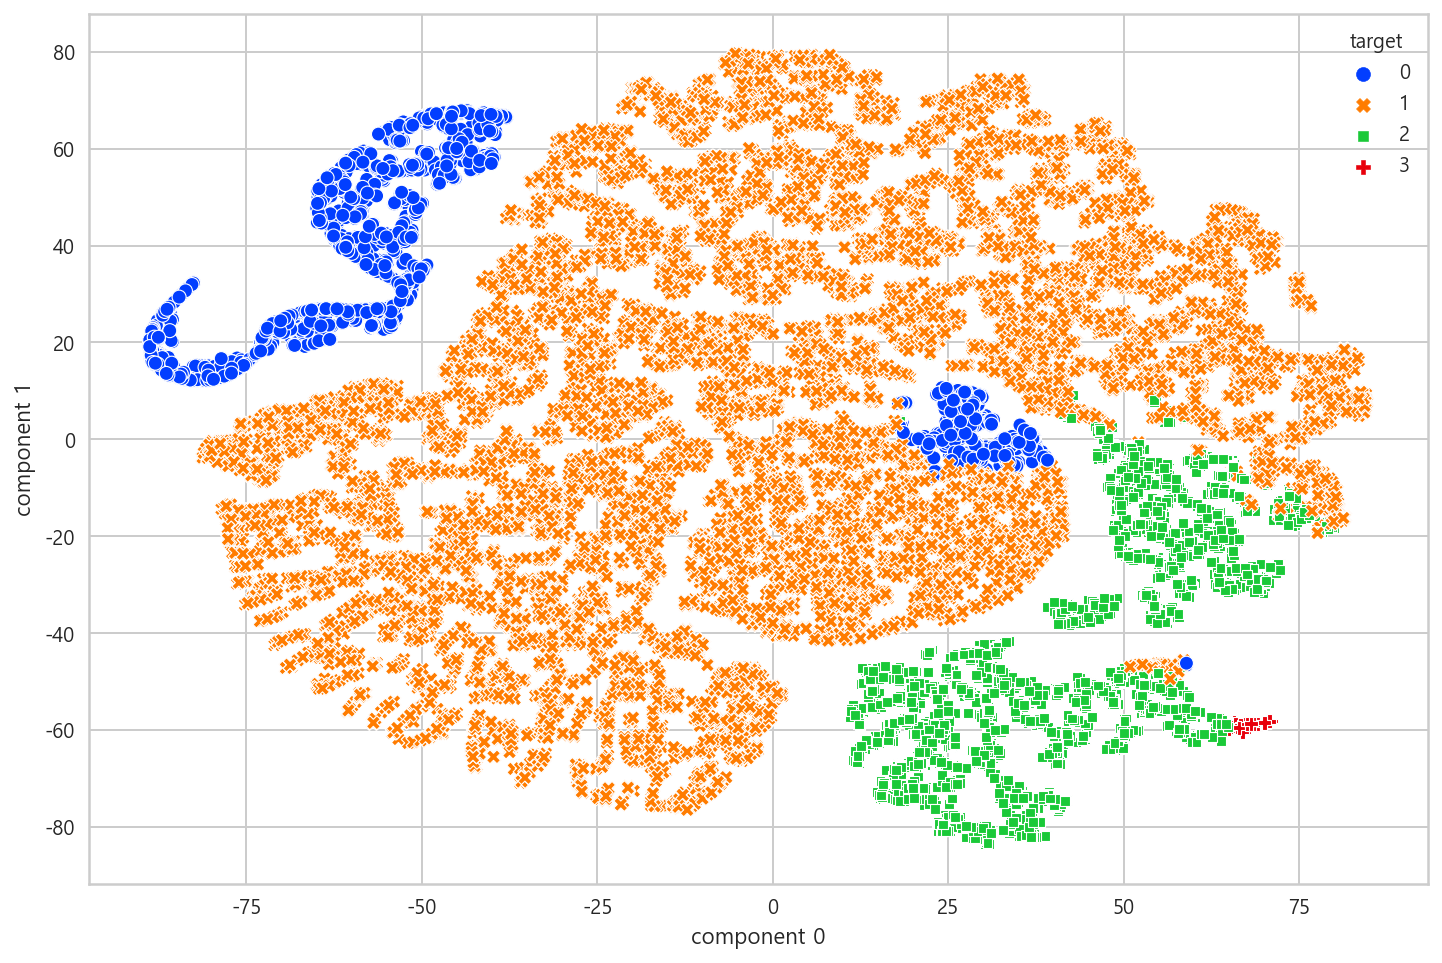

In [17]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = tsne_df['component 0'], y = tsne_df['component 1'],
               hue = tsne_df['target'],
               style = tsne_df['target'],
               palette = 'bright')
plt.show()

### PCA

In [18]:
df_pca = rfm_scaled_df.set_index('Customer_ID').iloc[:,:-1]
df_pca

,Recency,Frequency,Monetary
Customer_ID,,,
M000034966,0.388787,-0.682454,-0.292294
M000136117,0.549046,0.211318,1.677066
M000201112,-0.183566,-0.776535,-0.331906
M000225114,0.571940,0.199558,-0.189339
M000261625,-0.046201,-0.259088,0.090332
...,...,...,...
M999673157,0.274316,-0.635413,-0.135540
M999770689,0.571940,1.704857,-0.189724
M999849895,-0.114884,-0.423730,-0.258696


In [19]:
from sklearn.decomposition import PCA
X_scale = StandardScaler().fit_transform(df_pca)
pca = PCA().fit(X_scale)
np.cumsum(pca.explained_variance_ratio_)

array([0.50507464, 0.79980403, 1.        ])

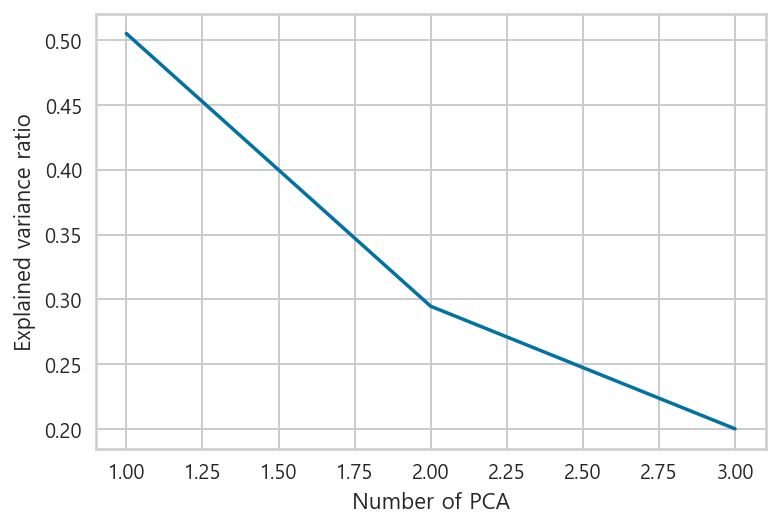

In [20]:
plt.plot(np.arange(1,X_scale.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Number of PCA')
plt.ylabel('Explained variance ratio')
plt.show()

In [21]:
x_reduced = pca.transform(X_scale)

In [22]:
def biplot(score,coeff, labels=None, index = rfm_scaled_df.index):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    for i in range(score.shape[0]):
        if index is None:
            plt.text((xs * scalex)[i] , (ys * scaley)[i], str(i))
        else:
            plt.text((xs * scalex)[i] , (ys * scaley)[i], index[i])

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

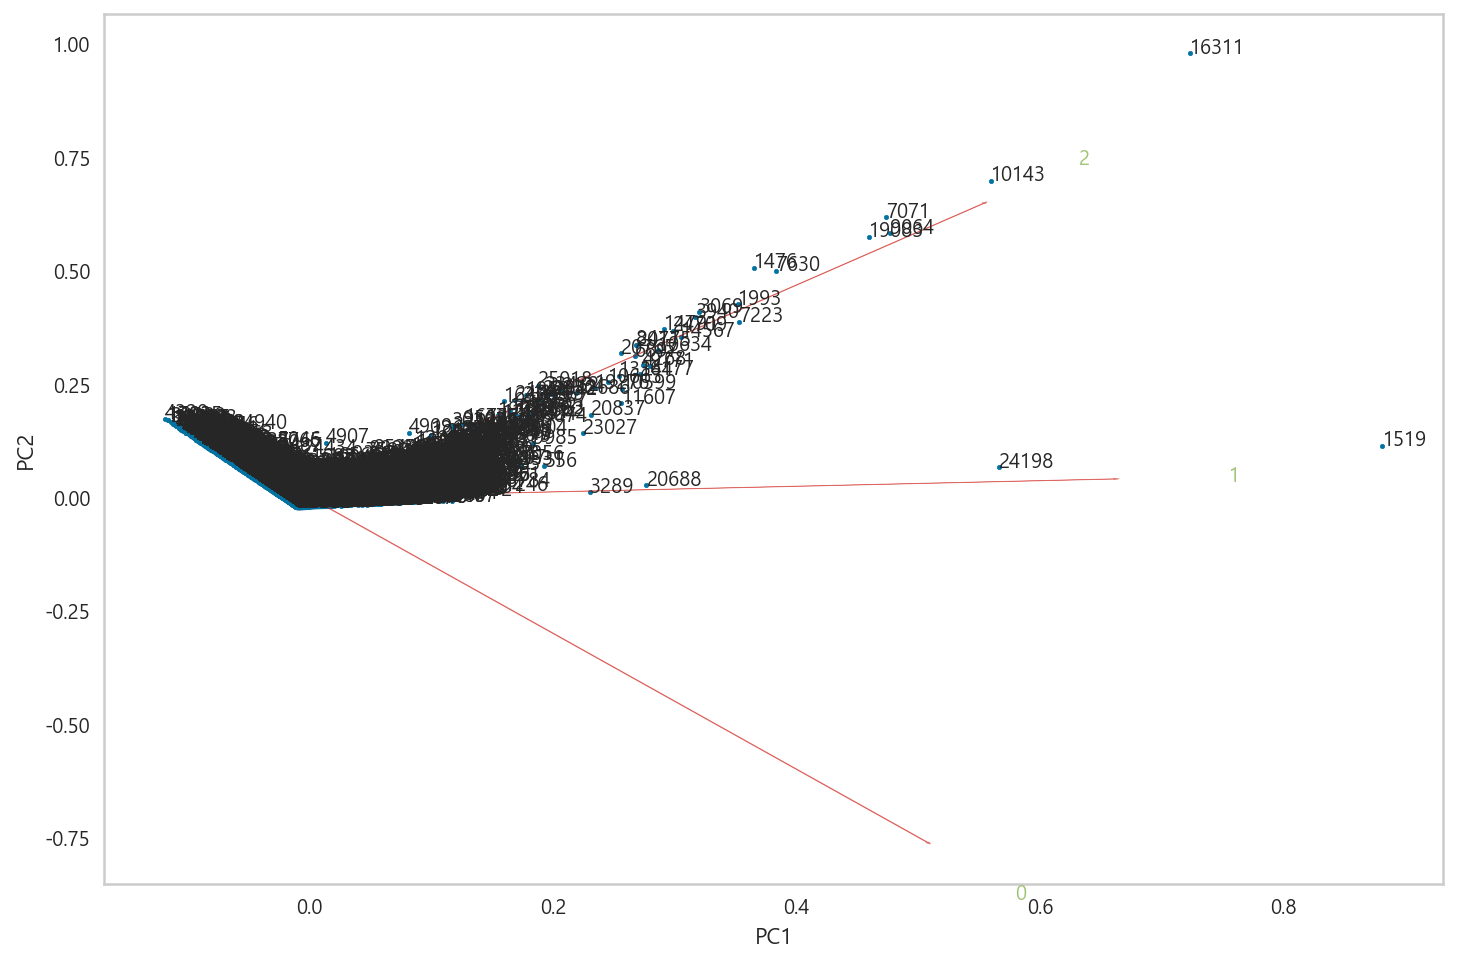

In [23]:
plt.figure(figsize=(12,8))
biplot(x_reduced[:,0:2],np.transpose(pca.components_[0:2, :]), rfm_scaled_df.index)

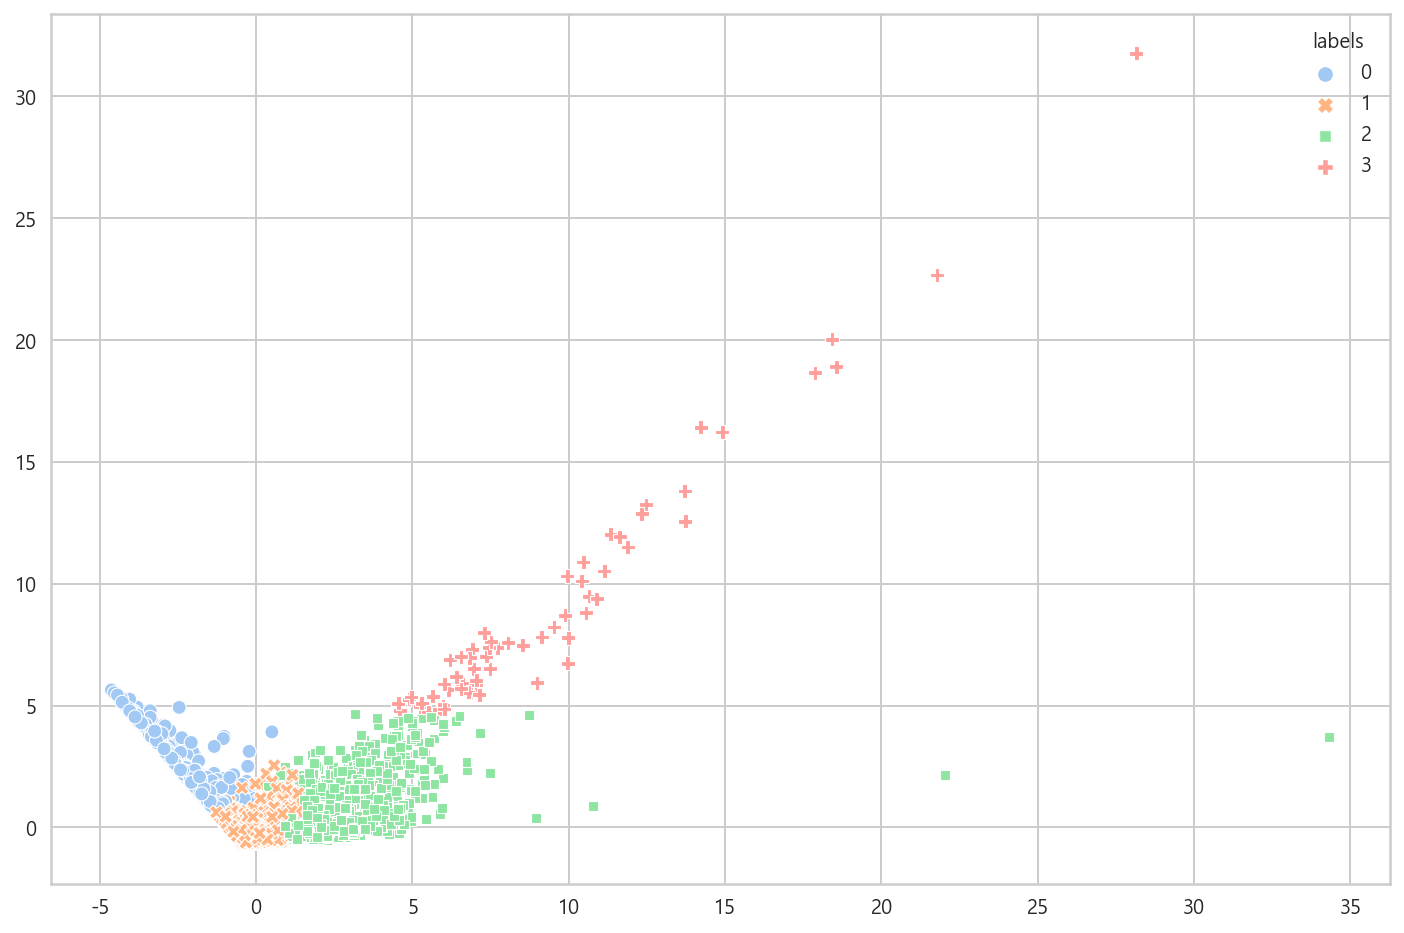

In [24]:
# x축 PC1, y축 PC2
plt.figure(figsize = (12, 8))
sns.scatterplot(x = x_reduced[:,0], y = x_reduced[:,1],
               hue = rfm_scaled_df.labels,
               style = rfm_scaled_df.labels,
               palette='pastel')
plt.show()